# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [ ]:
%%capture
%conda install tensorflow
%conda install numpy
%conda install matplotlib
%pip install tensorflow-addons
%pip install seaborn
%pip install imageio

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os, random, json, PIL, shutil, re, imageio, glob
from tensorflow.keras.callbacks import Callback  
tf.random.set_seed(0)
print(tf.__version__)
tf.random.set_seed(0)

In [ ]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)


In [ ]:
print(tf.config.list_physical_devices('GPU'))

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [ ]:
#tf.io.gfile.glob: Returns a list of files that match the given pattern(s).
MONET_FILENAMES = tf.io.gfile.glob(str('monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))
PHOTO_FILENAMES = tf.io.gfile.glob(str('photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

In [ ]:
# Obtain two lists of files that match the given patterns specified in str()
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:
IMAGE_SIZE = [256, 256]
BUFFER_SIZE = 1000
BATCH_SIZE =  4
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 10

def decode_image(image): 
    image = tf.image.decode_jpeg(image, channels=3)#Decode a JPEG-encoded image to a uint8 tensor. return type:A Tensor of type string.
    image = (tf.cast(image, tf.float32) / 127.5) - 1 #unit8: Unsigned Integers of 8 bits. String -> float32.  scaling to [0,1] 
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) #reshape to [256,256,3]
    return image


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string), 
        "image": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format) # parse the tf file in to tfrecord_format format.
    #Return A dict mapping feature keys to Tensor and SparseTensor values.
    image = decode_image(example['image'])# decode jpeg to float32.
    return image # We only need the image

Define the function to extract the image from the files.

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames) #A Dataset comprising records from one or more TFRecord files. dataset: tf.data.Dataset
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1) #batch(batch_size, ...) size = 1就是全放一起
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [ ]:
def view_image(ds, nrows=1, ncols=5):
    ds_iter = iter(ds)
    # image = next(iter(ds)) # extract 1 from the dataset
    # image = image.numpy()  # convert the image tensor to NumPy ndarrays.

    fig = plt.figure(figsize=(25, nrows * 5.05 )) # figsize with Width, Height
    
    # loop thru all the images (number of rows * number of columns)
    for i in range(ncols * nrows):
        image = next(ds_iter)
        image = image.numpy()
        ax = fig.add_subplot(nrows, ncols, i+1, xticks=[], yticks=[])
        ax.imshow(image[0] * 0.5 + .5) # rescale the data in [0, 1] for display

In [ ]:
view_image(monet_ds,2, 6)

In [ ]:
view_image(photo_ds,2, 6)

In [ ]:
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
        
    if shuffle:
        monet_ds = monet_ds.shuffle(1024, reshuffle_each_iteration=True)
        photo_ds = photo_ds.shuffle(1024, reshuffle_each_iteration=True)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    # monet_ds = monet_ds.cache()
    # photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

In [ ]:
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Apply jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    # Random rotation
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    # Random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

In [ ]:
full_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
example_monet , example_photo = next(iter(full_dataset))

Let's  visualize a photo example and a Monet example.

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Monet")
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.show()

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size,stride=2, apply_instancenorm=True):#filter = Integer, the dimensionality of the output space,size = kernel size普通卷积 大变小
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02) #Initializer that generates tensors with a normal distribution
 
    result = keras.Sequential() #Sequential groups a linear stack of layers into a tf.keras.Model.
    #from tensorflow.keras import layers
    result.add(layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)) #Instance normalization layer. Inherits From: GroupNormalization
        #tfa.layers.GroupNormalization:Group normalization layer.
        #gamma weight 搞不懂，应该是统计学上的东西吧，gamma distribution？

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [ ]:
def upsample(filters, size,stride=2, apply_dropout=False):#小变大
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    #tf.keras.layers.Conv2DTranspose: Transposed convolution layer (sometimes called Deconvolution).
    result.add(layers.Conv2DTranspose(filters, size, strides=stride, 
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3]) #图片格式 256*256*3

    # bs = batch size
    down_stack = [
        downsample(64, 7, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]#叠了很多个conv2d layer

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]#叠了很多个Tansposeconv2d layer

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 7,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)#还原

    x = inputs

    # Downsampling through the model
    skip_connection = 7
    skips = []
    for down in down_stack: #down 是一个实例layer，只用传图(x)进去了
        x = down(x) #往下卷！
        skips.append(x)
    skips = reversed(skips[:-1])#为啥要reverse。。。因为skip connections中，同层的down和up相互对应，上面俩是反着的。。。
    
    # Upsampling and establishing the skip connections

    for up, skip in zip(up_stack, skips):
        x = up(x)#往上还原！
        if skip_connection <= 4:
            x = layers.Concatenate()([x, skip])#只拼接downsampling前的
        skip_connection = skip_connection-1

    x = last(x)#生成预测，和input一层，所以单独放在外面，上面的都是卷积层。

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4,2, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4,2)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4,2)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256) #不懂在干什么。。。。只知道在加了些0，也许是为了凑34？
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    #是否需要DENSE layer,研究下

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with tf.device("/GPU:0"):#和try catch 一个意思的样子, strategy应该TPU的运行环境
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# Load Pretrained Data

In [ ]:
# with tf.device("/GPU:0"):
#     monet_generator = keras.models.load_model('monet_generator00.h5')
#     photo_generator = keras.models.load_model('photo_generator00.h5')
#     monet_discriminator = keras.models.load_model('monet_discriminator00.h5')
#     photo_discriminator = keras.models.load_model('photo_discriminator00.h5')

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

In [ ]:
with tf.device("/GPU:0"):
    to_monet = monet_generator(example_photo)

plt.figure(figsize=(25, 25 ))
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [ ]:
with tf.device("/GPU:0"):
    to_photo = photo_generator(example_monet)

plt.figure(figsize=(25, 25 ))
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_photo[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__() #super(CycleGan, self) 和 super（）应该是一样的，“In Python 3, the super(Square, self) call is equivalent to the parameterless super() call.”
        self.m_gen = monet_generator#只是说 super(CycleGan, self)，CycleGan可以换成其他，相当于可以调用其他类的 super()
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile( #Configures the model for training.
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape: #Record operations for automatic differentiation. persistent=True 是让微分留在内存，不然会被garbage collected.
            #Boolean controlling whether a persistent gradient tape is created. False by default, 
            #which means at most one call can be made to the gradient() method on this object.
            
            # photo to monet back to photo  
            fake_monet = self.m_gen(real_photo, training=True)#真照片 ->假莫奈画
            print(fake_monet)
            cycled_photo = self.p_gen(fake_monet, training=True)#假莫奈画->还原照片

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)#真莫奈画 ->假照片
            cycled_monet = self.m_gen(fake_photo, training=True)#假照片 ->还原莫奈画

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)#真莫奈画 ->假莫奈画
            same_photo = self.p_gen(real_photo, training=True)#真照片->假照片

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)#判断真莫奈画 
            disc_real_photo = self.p_disc(real_photo, training=True)#判断真照片

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)#判断假莫奈画 
            disc_fake_photo = self.p_disc(fake_photo, training=True)#判断假照片

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
with tf.device("/GPU:0"):
    def discriminator_loss(real, generated):
        #真的都是1,所以和 tf.ones_like 对比
        #real_loss = tf.square(tf.ones_like(real) - real)
        
        #假的都是0,所以和 tf.zeros_like 对比     

        #generated_loss = tf.square(generated)

        #total_disc_loss = real_loss + generated_loss
        
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss


        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with tf.device("/GPU:0"):
    def generator_loss(generated):
        #我们希望discriminator都给1，所以和1's比
       # return tf.square(tf.ones_like(generated) - generated)
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with tf.device("/GPU:0"):
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        #loss1 = tf.reduce_mean(tf.square(real_image - cycled_image))
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with tf.device("/GPU:0"):
    def identity_loss(real_image, same_image, LAMBDA):
        #loss = tf.reduce_mean(tf.square(real_image - same_image))
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [ ]:

@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.

    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8

    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [ ]:
with tf.device("/GPU:0"):
# Callbacks
    class GANMonitor(Callback):
        """A callback to generate and save images after each epoch"""

        def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
            self.num_img = num_img
            self.monet_path = monet_path
            self.photo_path = photo_path
            self.epoch = 0
            self.N = 5
            # Create directories to save the generate images
            if not os.path.exists(self.monet_path):
                os.makedirs(self.monet_path)
            if not os.path.exists(self.photo_path):
                os.makedirs(self.photo_path)

        def on_epoch_end(self, epoch, logs=None):
            # Monet generated images
            for i, img in enumerate(photo_ds.take(self.num_img)):
                prediction = monet_generator(img, training=False)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                prediction = PIL.Image.fromarray(prediction)
                prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')

            # Photo generated images
            for i, img in enumerate(monet_ds.take(self.num_img)):
                prediction = photo_generator(img, training=False)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                prediction = PIL.Image.fromarray(prediction)
                prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

            if self.epoch % self.N == 0:
                name1 = 'monet_generator%02d.h5' % self.epoch
                name2 = 'photo_generator%02d.h5' % self.epoch
                name3 = 'monet_discriminator%02d.h5' % self.epoch
                name4 = 'photo_discriminator%02d.h5' % self.epoch
                monet_generator.save(name1)
                photo_generator.save(name2)
                monet_discriminator.save(name3)
                photo_discriminator.save(name4)
            self.epoch += 1

In [ ]:
with tf.device("/GPU:0"):
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    # lr_monet_disc =0.002
    # lr_photo_disc = 0.002
    
    
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

In [ ]:
with tf.device("/GPU:0"):
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
with tf.device("/GPU:0"):
    history = cycle_gan_model.fit(full_dataset,
                        callbacks=[GANMonitor()],
                        epochs=EPOCHS,
                        steps_per_epoch=( max(n_monet_samples, n_photo_samples)//BATCH_SIZE),
                        verbose=1).history

In [ ]:
history.keys()

In [ ]:
plt.plot(np.mean(np.array(history['monet_gen_loss']),axis = (1,2,3)))
plt.plot(np.mean(np.array(history['photo_gen_loss']),axis = (1,2,3)))
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['monet', 'photo'], loc='upper left')
plt.show()


plt.plot(np.mean(np.array(history['monet_disc_loss']),axis = (1,2,3)))
plt.plot(np.mean(np.array(history['photo_disc_loss']),axis = (1,2,3)))
plt.title('Discriminator Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['monet', 'photo'], loc='upper left')
plt.show()

# Visualize our Monet-esque photos

In [37]:
with tf.device("/GPU:0"):
    def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
        fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
        axes = axes.flatten()

        ds_iter = iter(ds)
        for n_sample in range(n_samples):
            idx = n_sample*3
            example_sample = next(ds_iter)
            generated_a_sample = generator_a.predict(example_sample)
            generated_b_sample = generator_b.predict(generated_a_sample)

            axes[idx].set_title('Input image', fontsize=18)
            axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
            axes[idx].axis('off')

            axes[idx+1].set_title('Generated image', fontsize=18)
            axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
            axes[idx+1].axis('off')

            axes[idx+2].set_title('Cycled image', fontsize=18)
            axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
            axes[idx+2].axis('off')

        plt.show()

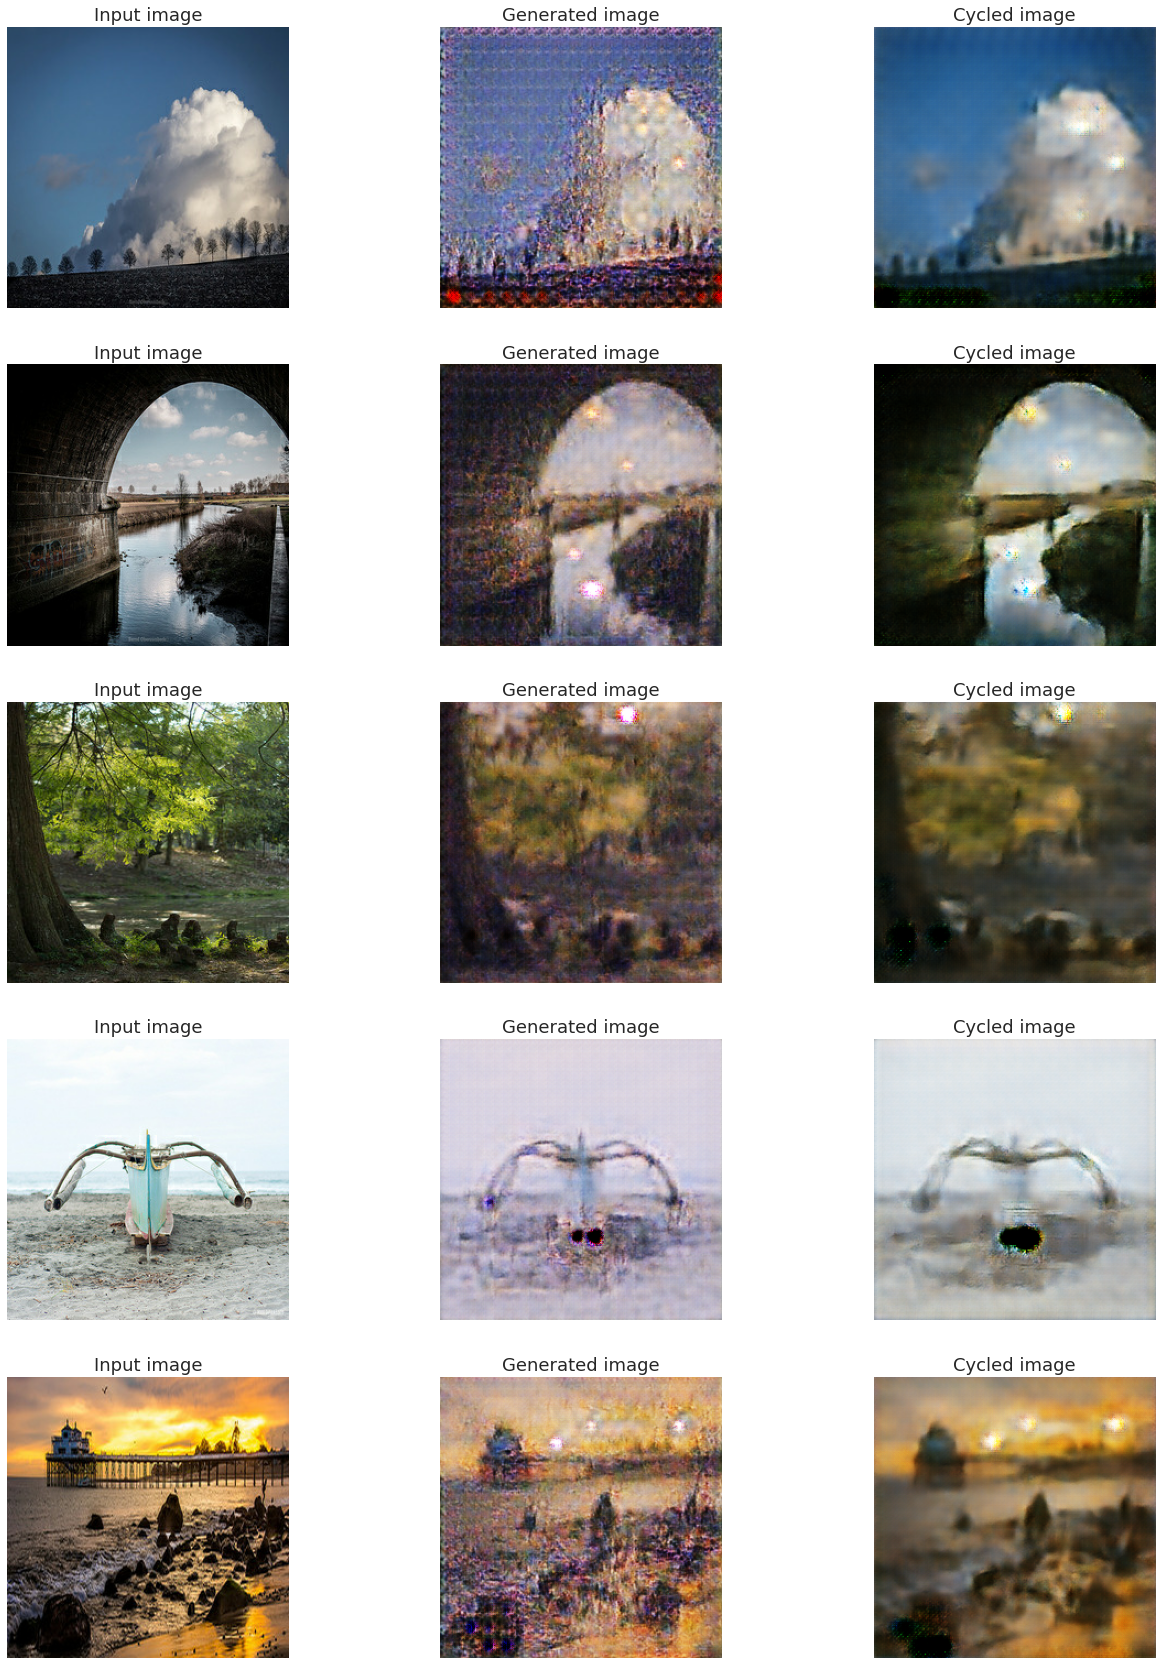

In [38]:
with tf.device("/GPU:0"):
    evaluate_cycle(photo_ds.take(5), monet_generator, photo_generator, n_samples=5)

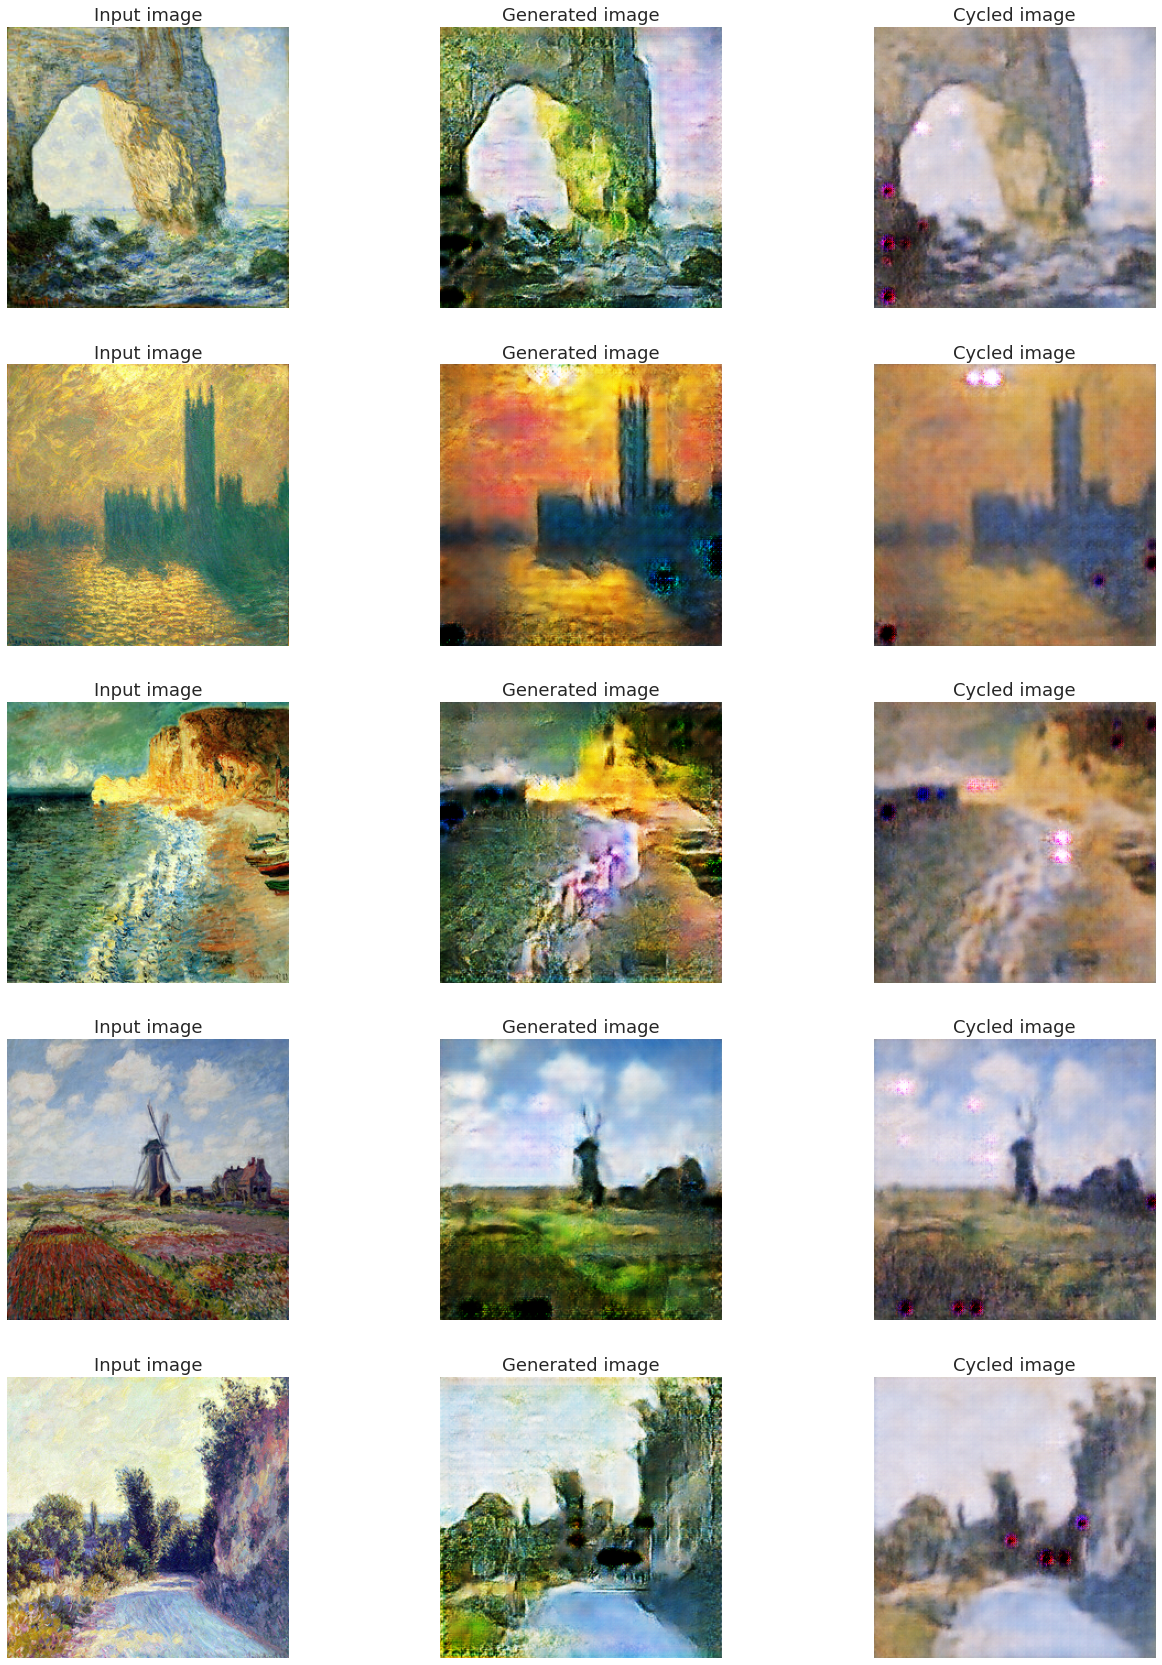

In [39]:
with tf.device("/GPU:0"):
    evaluate_cycle(monet_ds.take(5), photo_generator,monet_generator, n_samples=5)

# Saving the Model

In [42]:
monet_generator.save('monet_generator.h5')
photo_generator.save('photo_generator.h5')
monet_discriminator.save('monet_discriminator.h5')
photo_discriminator.save('photo_discriminator.h5')

# Monet generation GIF

In [40]:
def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif

In [48]:
create_gif('photo/*.png', 'photo.gif') 

In [49]:
create_gif('monet/*.png', 'monet.gif')

# Create submission file

In [ ]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [ ]:
%%time
os.makedirs('../images/') # Create folder to save generated images
predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [ ]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")